# Exercise 10 - Applying ESNs to the Lorenz System

- In the lecture, we trained an ESN to reproduce the dynamics of the Lorenz system, correctly predicting the Lorenz trajectory up to ~10 Lyapunov times. After this time, the predicted trajectory deviates from the actual Lorenz trajectory, which is expected since small errors grow exponentially due to the chaotic dynamics of the Lorenz system. 


- Do the long-term dynamics of the ESN still constitute a valid Lorenz trajectory? Investigate this question by:
    1. Plotting the attractor of the ESN for a long integration and comparing it qualitatively with the true Lorenz attractor.
    2. Compute the maximum Lyapunov exponent of the ESN dynamics and compare it to the maximum Lyapunov exponent of the Lorenz system.
    

- Bonus: In the lecture, we performed a grid-search on the ESN hyperparameters and kept the model with the lowest error on the validation set. However, because the reservoir is generated randomly, there is some variance in the performance of an ESN for a given set of hyperparameters, meaning that the optimal hyperparameters chosen by cross-validation may not be detereministic. Extend the cross-validation procedure to generate and fit multiple ESNs for each combination of hyperparameters, keeping only the best one. Does this improve the prediction horizon of the ESN?

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add(["DynamicalSystems", "ReservoirComputing", "Plots", "Printf"])

  Activating project at `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-12`
   Resolving package versions...
  No Changes to `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-12/Project.toml`
  No Changes to `/p/tmp/alistair/TUM-Dynamics-Lecture/exercises/exercise-12/Manifest.toml`


In [2]:
using DynamicalSystems, ReservoirComputing, Plots, Printf

In [3]:
# Helper functions from the lecture

"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)
    N = size(data, 2)
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end


"""
    train_esn!(esn, y, ridge_param)

Given an Echo State Network, train it on the target sequence y_target and return the optimised output weights Wₒᵤₜ.
"""
function train_esn!(esn, y_target, ridge_param)
    training_method = StandardRidge(ridge_param)
    return train(esn, y_target, training_method)
end


"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end

"""
Hyperparameters for an Echo State Network.
"""
struct ESNHyperparams
    reservoir_size
    spectral_radius
    sparsity
    input_scale
    ridge_param
end

ESNHyperparams

In [4]:
# Set up the Lorenz system
ds = Systems.lorenz63()

# Compute the maximum Lyapunov exponent of the system (we will use this to benchmark the model predictions later)
λ_max = lyapunov(ds, 100, Ttr = 100)

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0

tr = trajectory(ds, T, Δt = Δt, Ttr = Ttr)[1]
x, y, z = columns(tr)

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = reduce(vcat, [x, y, z]')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

## Cross-Validation

- We do the bonus part of the exercise first and experiment with alternative cross-validation techniques.


- In particular, we should point out two important modifications to the method `cross_validate_esn` compared to the one we used in the lecture:
    1. We now reuse the reservoir connections matrix $\mathbf W$ and the input matrix $\mathbf W^{\mathrm{in}}$ of the best model. In the lecture, we simply stored the hyperparameters of the best model and used them to generate a new ESN, and in turn a new $\mathbf W$ and the input matrix $\mathbf W^{\mathrm{in}}$. However, due to the randomness in the ESN generation, it's possible that this new reservoir would turn out to be suboptimal.
    2. For each combination of hyperparameters, we now have the option of generating and evaluating multiple ESNs, to account for the possibility of individual ESNs which perform poorly. This is controlled by the `iters` keyword argument of `cross_validate_esn`.
    
   
- To keep the runtime to a minimum, we will only optimise the spectral radius of the reservoir, but feel free to experiment with other hyperparameter values.

In [5]:
using ReservoirComputing: AbstractDriver, NonLinearAlgorithm, NLADefault, AbstractStates,
    StandardStates, RNN, reservoir_driver_params, create_states

# Custom ESN constructor that takes already initialized input matrix and reservoir matris
function re_init_ESN(
    train_data::AbstractArray, 
    input_matrix::AbstractMatrix,
    reservoir_matrix::AbstractMatrix;
    bias_vector=zeros32(size(reservoir_matrix,1)),
    reservoir_driver::AbstractDriver=RNN(),
    nla_type::NonLinearAlgorithm=NLADefault(),
    states_type::AbstractStates=StandardStates(),
    washout::Int=0,
    )
    res_size = size(reservoir_matrix, 1)
    
    # Reshape train_data if necessary to match input matrix
    if size(train_data, 1) != size(input_matrix, 2)
        train_data = reshape(train_data, size(input_matrix, 2), :)
    end
    
    inner_res_driver = reservoir_driver_params(reservoir_driver, res_size, size(train_data,1))
    states = create_states(inner_res_driver, train_data, washout, reservoir_matrix,
        input_matrix, bias_vector)
    train_data = train_data[:, (washout + 1):end]

    ESN(
        res_size,
        train_data,
        nla_type,
        input_matrix,
        inner_res_driver,
        reservoir_matrix,
        bias_vector,
        states_type,
        washout,
        states,
    )
end

"""
    cross_validate_esn(train_data, val_data, param_grid)

Do a grid search on the given param_grid to find the optimal hyperparameters.
"""
function cross_validate_esn(train_data, val_data, param_grid; iters = 1)
    best_loss = Inf
    best_params = nothing
    best_esn = nothing

    # We want to predict one step ahead, so the input signal is equal to the target signal from the previous step
    u_train = train_data[:, 1:end-1]
    y_train = train_data[:, 2:end]
        
    for hyperparams in param_grid
        # Unpack the hyperparams struct
        (;reservoir_size, spectral_radius, sparsity, input_scale, ridge_param) = hyperparams

        for _ in 1:iters
            # Generate and train an ESN
            esn = ESN(
                u_train,
                3,
                reservoir_size;
                reservoir=rand_sparse(; radius=spectral_radius, sparsity=sparsity),
                input_layer=scaled_rand(; scaling=input_scale),
            )
            Wₒᵤₜ = train_esn!(esn, y_train, ridge_param)

            # Evaluate the loss on the validation set
            steps_to_predict = size(val_data, 2)
            prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
            loss = sum(abs2, prediction - val_data)

            # Keep track of the best hyperparameter values
            if loss < best_loss
                best_loss = loss
                best_params = hyperparams
                best_esn = esn
                println(hyperparams)
                @printf "Validation loss = %.1e\n" best_loss
            end
        end
    end
    
    # Retrain the model using the optimal hyperparameters on both the training and validation data
    # This is necessary because we don't want errors incurred during validation to affect the test error
    data = hcat(train_data, val_data)
    u = data[:, 1:end-1]
    y = data[:, 2:end]
    esn = re_init_ESN(u, best_esn.input_matrix, best_esn.reservoir_matrix)
    Wₒᵤₜ = train_esn!(esn, y, best_params.ridge_param)
    
    return esn, Wₒᵤₜ
end

cross_validate_esn

In [6]:
# Set up the hyperparameter grid-search
param_grid = []

reservoir_sizes = [1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0, 1e-6, 1e-5]

# Take the Cartesian product of the possible values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparams(params...))
end

println(length(param_grid), " hyperparameter combinations.")

18 hyperparameter combinations.


ESNHyperparams(1024, 0.8, 0.03, 0.1, 0.0)
Validation loss = 1.7e+04
ESNHyperparams(1024, 1.0, 0.05, 0.1, 1.0e-6)
Validation loss = 1.5e+04
258.958907 seconds (17.67 M allocations: 14.988 GiB, 0.42% gc time, 3.15% compilation time)


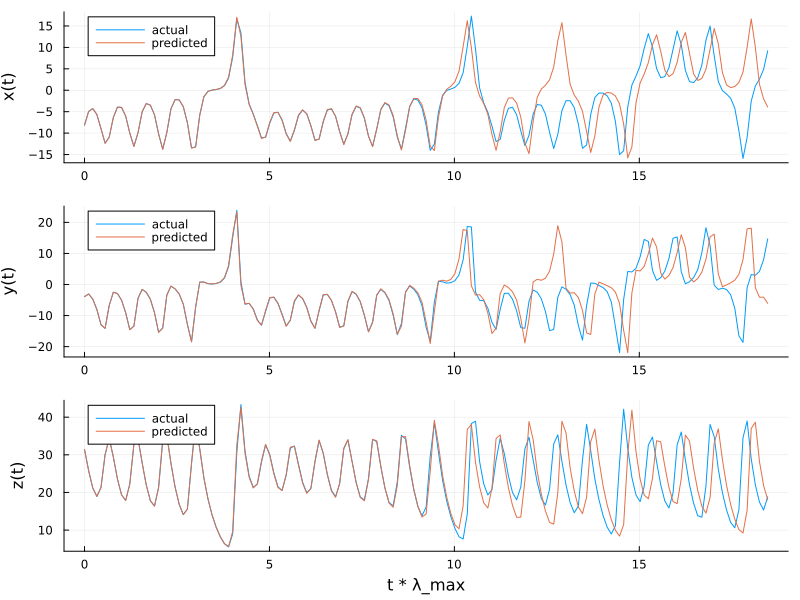

In [7]:
train_data, val_data, test_data = train_val_test_split(data, val_seconds = 15 / λ_max, test_seconds = 15 / λ_max);
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid, iters = 10)
plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

- Based on our experiments, it is difficult to reliably obtain a meaningful prediction beyond ~10 Lyapunov times (which is still **very** good), although we did observe occasional models capable of predicting up to 13-14 Lyapunov times. Once again, feel free to experiment.

- Not that there was a mistake in the lecture notes, where we multiplied with the Lyapunov exponent instead of dividing.

## Plotting the Lorenz Attractor of the ESN

In [8]:
# Generate a trajectory from the trained ESN
steps_to_predict = length(tr)
predicted_trajectory = esn(Generative(steps_to_predict), Wₒᵤₜ)
predicted_trajectory = StateSpaceSet(predicted_trajectory')  # Put the data in a StateSpaceSet object for DynamicalSystems.jl 

3-dimensional StateSpaceSet{Float64} with 2001 points
  -8.14085     -3.89888   31.4146
  -4.9451      -3.04346   25.8012
  -4.26632     -4.68971   21.2103
  -5.66151     -8.02579   18.9418
  -8.938      -12.9322    21.3232
 -12.3647     -14.1094    30.0545
 -10.9371      -6.74084   34.3703
  -6.36538     -2.47474   29.4179
  -3.93252     -2.89276   23.5831
  -3.99102     -5.04595   19.3606
  -6.02197     -9.07775   17.8742
 -10.0006     -14.5349    22.2355
 -13.103      -13.392     32.7702
   ⋮                      
 -11.9915      -6.14081   37.0079
  -5.58152     -0.251116  30.262
  -2.21202     -0.538158  23.2397
  -1.56604     -1.71058   17.9644
  -2.3114      -3.68967   14.1979
  -4.60362     -8.04621   12.6104
  -9.63477    -16.1883    17.3386
 -15.2239     -17.1239    34.2489
 -10.7248      -1.97173   37.7791
  -3.21017      1.95362   28.5926
  -0.0987402    1.53805   21.6921
   1.00106      1.87907   16.6934

- Note: It doesn't matter that this trajectory has different initial conditions from the ground truth trajectory we generated earlier, as we are only interested in the qualitative shape of the attractor.

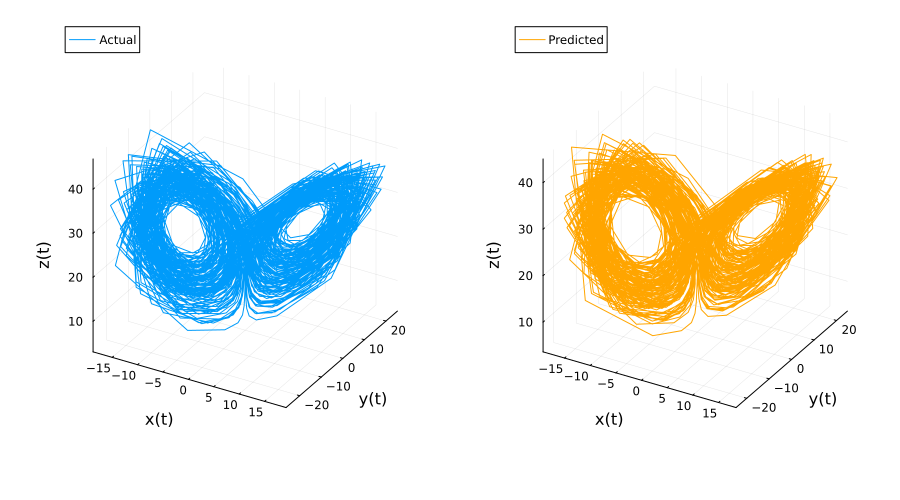

In [9]:
# Compare the Lorenz attractor of the predicted trajectory to the actual trajectory we computed earlier
p1 = plot(tr[:, 1], tr[:, 2], tr[:, 3], xlabel = "x(t)", ylabel = "y(t)", zlabel = "z(t)", label = "Actual")
p2 = plot(predicted_trajectory[:, 1], predicted_trajectory[:, 2], predicted_trajectory[:, 3], xlabel = "x(t)", ylabel = "y(t)", zlabel = "z(t)", label = "Predicted", color = :orange)
plot(p1, p2, layout = (1, 2), size = (900, 500))

- While the timestep is relatively large, rendering the plot not very smooth, the predicted attractor looks qualitatively reasonable, albeit not perfect.

## Estimating the Maximum Lyapunov Exponent from the Trained ESN

- For simplicity, we will reuse the method from exercise 6 for estimating Lyapunov exponents from data.

In [22]:
"""Helper function to compute the Lyapunov exponent and plot k x Δt versus E(k) - E(0)."""
function estimate_lyapunov(data, ks, Δt)    
    E = lyapunov_from_data(data, ks)   # Returns [E(k) for k ∈ ks]
    t = ks .* Δt
    (ind1, ind2), λ = linear_region(t, E; dxi=1)
    
    println("Identified linear region between t = ", t[ind1], " and t = ", t[ind2])
    println("Estimated Lyapunov exponent λ = ", round(λ, digits = 3))
    
    # Plotting
    xlim = maximum(ks .* Δt)
    ylim = maximum(E .- E[1])
    xticks_vals = 0:ks.step:xlim
    yticks_vals = 0:1:ylim
    
    plot(
        ks .* Δt, 
        E .- E[1],
        xlabel = "k x Δt",
        ylabel = "E(k) - E(0)",
        label = "λ=$(round(λ, digits = 3))",
        xticks = xticks_vals,
        yticks = yticks_vals,
        legend = :bottomright,
        size = (500, 500),
        linewidth = 2,
    )
end

estimate_lyapunov

Identified linear region between t = 1.0 and t = 1.5
Estimated Lyapunov exponent λ = 0.85


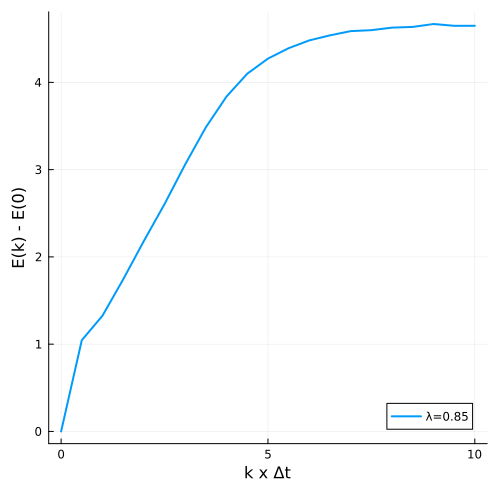

In [28]:
# Generate a long trajectory from the trained ESN
steps_to_predict = 10000
predicted_trajectory = esn(Generative(steps_to_predict), Wₒᵤₜ)
predicted_trajectory = StateSpaceSet(predicted_trajectory')  # Put the data in a StateSpaceSet object for DynamicalSystems.jl 

# Estimate the Lyapunov exponent
ks = 0:5:100
Δt = 0.1
estimate_lyapunov(predicted_trajectory, ks, Δt)

- Compared to the true Lyapunov exponent $\lambda_{\mathrm{max}} \approx 0.92$, this isn't bad at all. With a more robust hyperparameter search, and a better estimate of the slope, perhaps we could do even better.